In [1]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import plotly.express as px
import re
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler

In [3]:
alligator_annotations_github_testset = "../Results/alligator_annotations_github-testset_babakAlessandro_02_Github_Testset.json"

In [4]:
with open(alligator_annotations_github_testset, 'r') as f:
    data = json.load(f)

## Question: Which features are most important in finding the correct candidate?

### A.1 relation of each score to a candidate being the correct one
Let's have a look at how each feature is correlated to a candidate's correctness.

Suspicions:
- More than one correct candidate in the list => Probably since Lamapi adds it there without checking its existence
- Are candidates closely ranked? => yes they are
- Why are all duplicated correct candidates ranked 1 and 0? Are all 0 ranked correct candidates duplicated? => All mentions that are correctly predicted (Their rank is 1) have duplicated values in the candidates.
- How many do not have any correct candidate? => 289 rows don't have correct. All are NIL values, the rest did not have any candidate there for are not in the df.
- There are 3 rows that do ot have any correct candidate and are not NIL. I assumed Lamapi adds the correct candidate in the list. ??

In [5]:
## Find correct Qid for each row
correct_Qid = {row["idRow"]:row.get("ids", 'NIL') for row in data["rows"]}
rows = []

## For each annotation extract features and append binary value if the entity is correct
for annotation in data["semanticAnnotations"]["cea"]:
    for index, entity in enumerate(annotation["entity"]):
        is_correct = False
        # Check if the entity is correct
        if entity["id"] in correct_Qid[annotation["idRow"]]:
            is_correct = True

        id_row = annotation.get('idRow')
        id_column = annotation.get('idColumn')

        # Generate the key in the format "{idRow}-{idColumn}"
        key = f"{id_row}-{id_column}-{index}"

        # Extract features as a dictionary
        features = {feature['id']: feature['value'] for feature in entity.get('features', [])}
        features['key'] = key  # Include the custom key in the DataFrame
        features['is_correct'] = is_correct
        features['idRow'] = id_row
        features['idColumn'] = id_column
        features['index'] = index

        # Append the features dictionary to rows
        rows.append(features)

# Create DataFrame and set 'key' as index
candidate_features = pd.DataFrame(rows).set_index('key')

# sort by column name
candidate_features_sub = candidate_features.drop(columns=['idRow', 'idColumn', 'index', 'is_correct'])
candidate_features_sub.sort_index(inplace=True, axis=1)
candidate_features_sub[['idRow', 'idColumn', 'index', 'is_correct']] = candidate_features[['idRow', 'idColumn', 'index', 'is_correct']]
candidate_features = candidate_features_sub

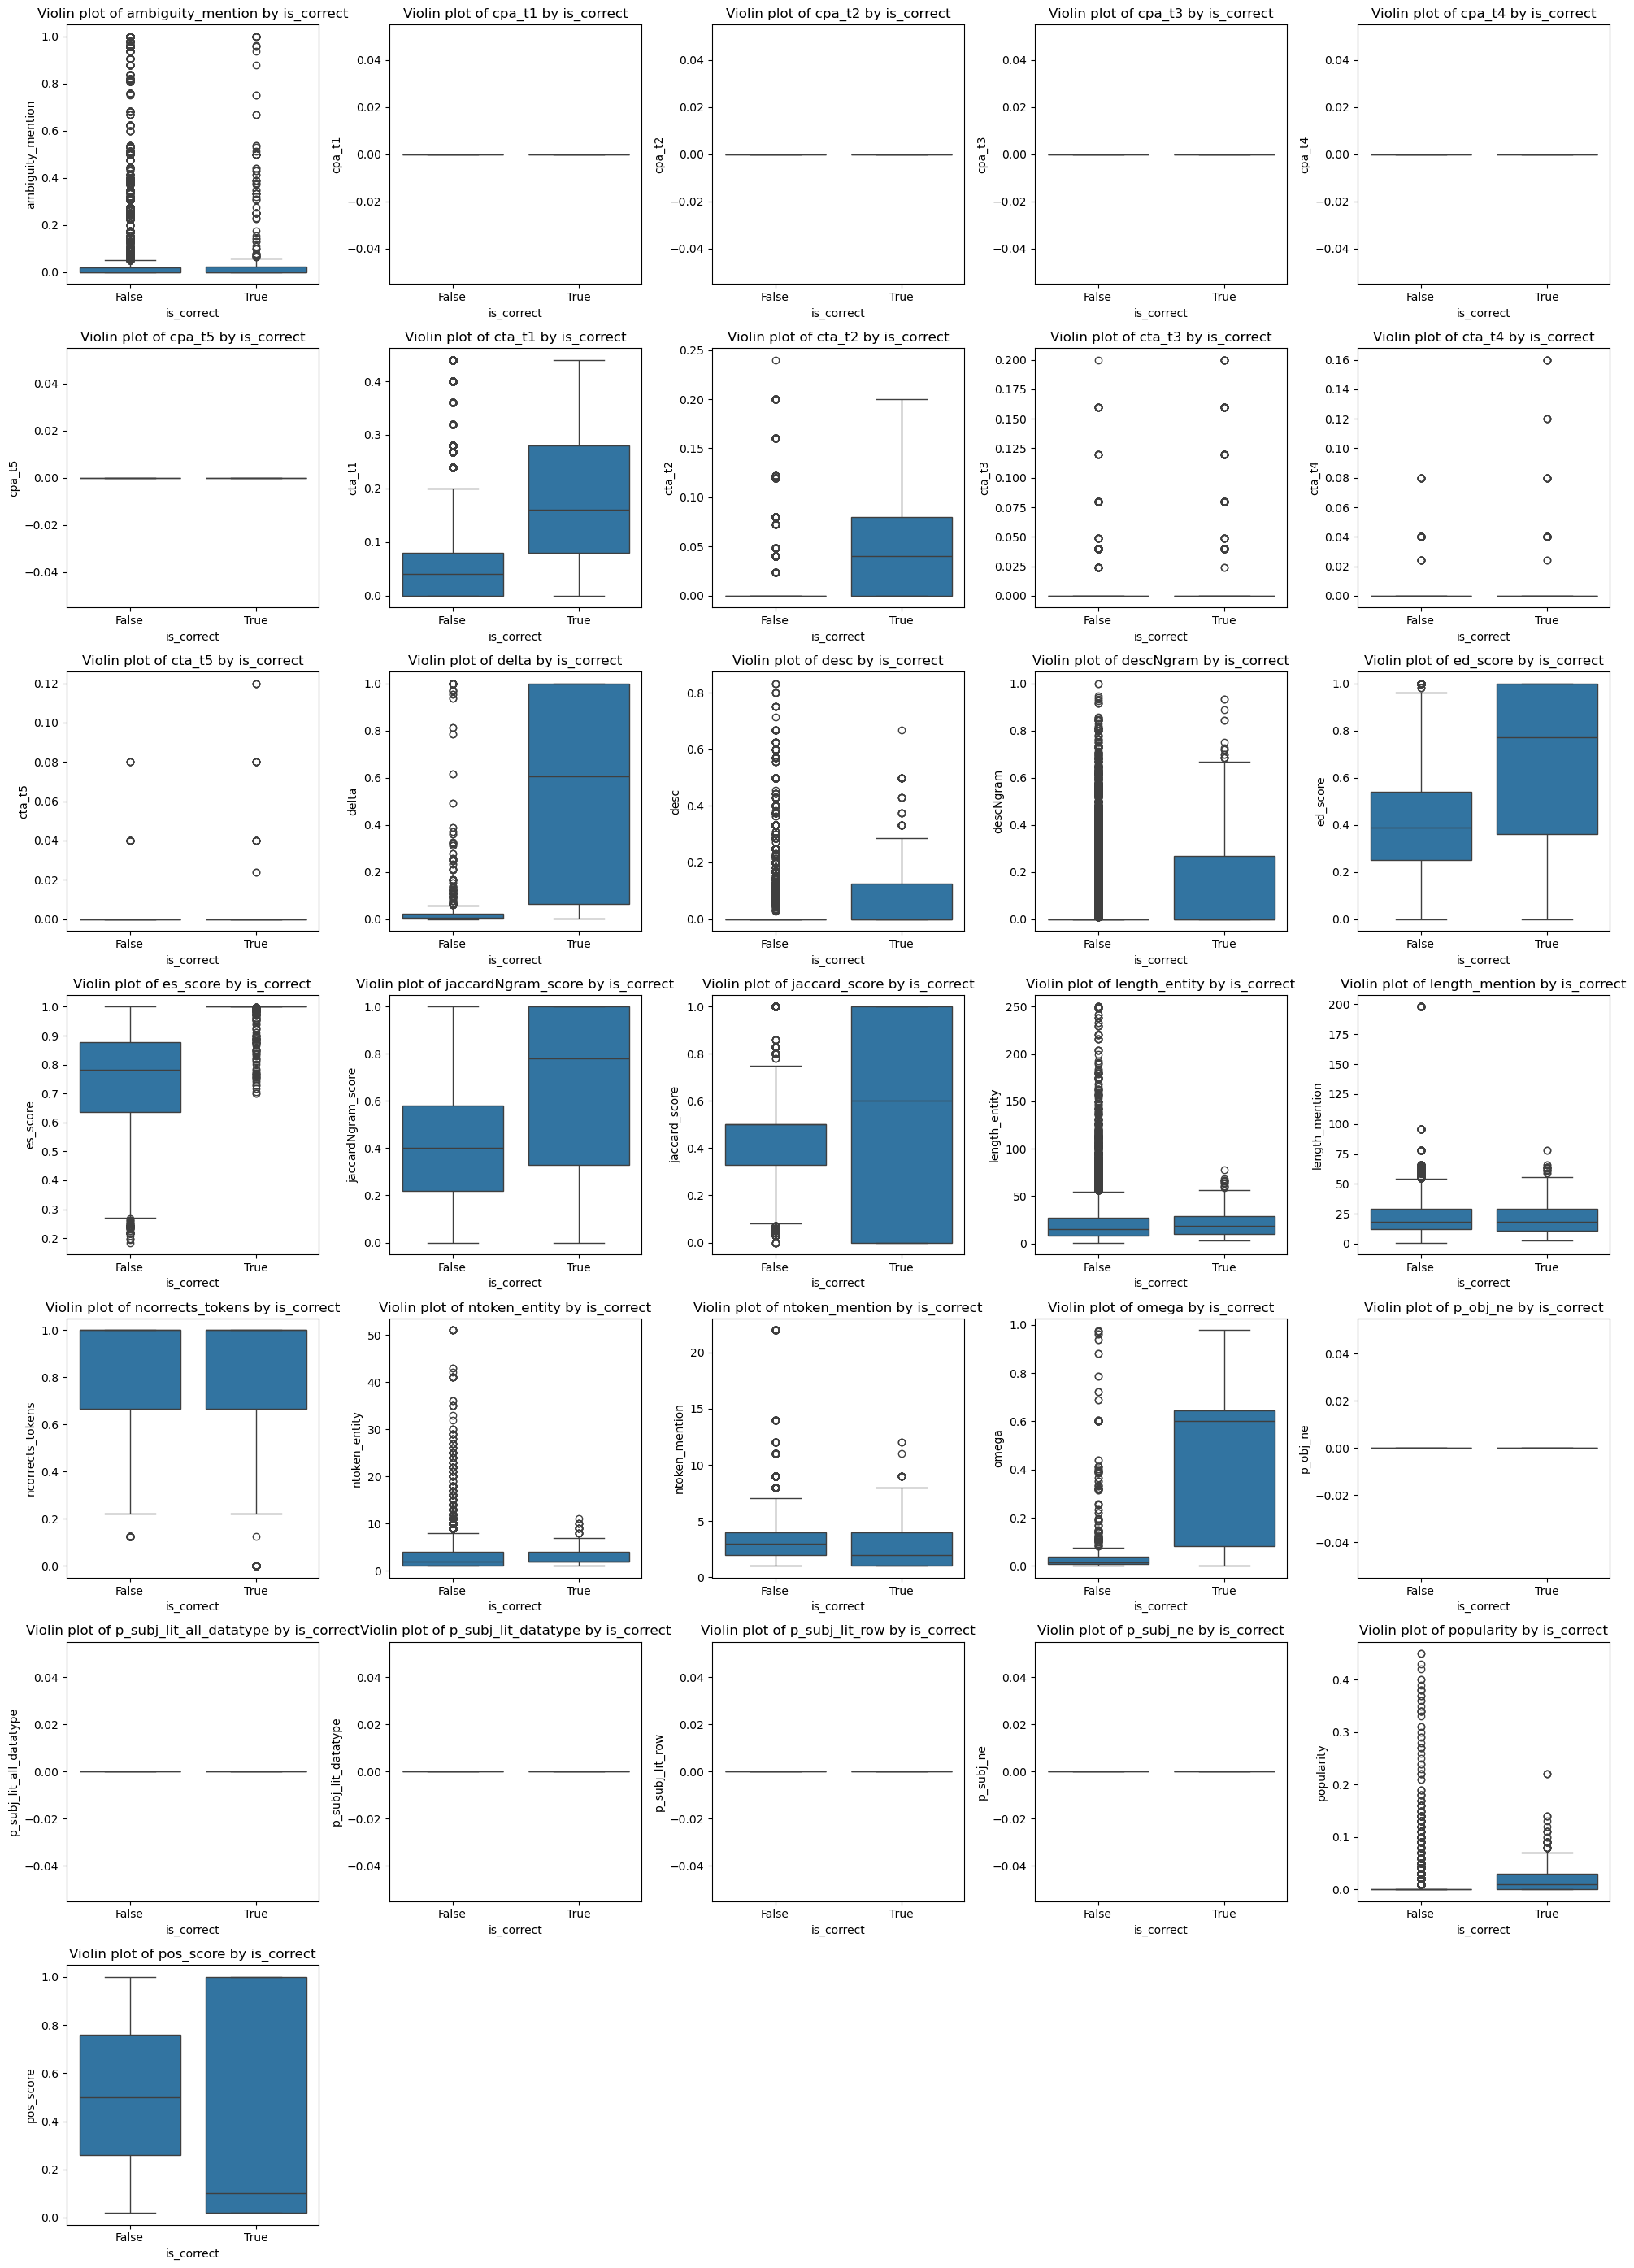

In [31]:
# List of columns to exclude
exclude_columns = ['idRow', 'idColumn', 'index', 'is_correct']

# Get the list of features to plot
features = [col for col in candidate_features.columns if col not in exclude_columns]

# Number of columns in the grid
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create violin plots for each feature
for i, feature in enumerate(features):
    sns.boxplot(x='is_correct', y=feature, data=candidate_features, ax=axes[i])
    axes[i].set_title(f'Violin plot of {feature} by is_correct')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

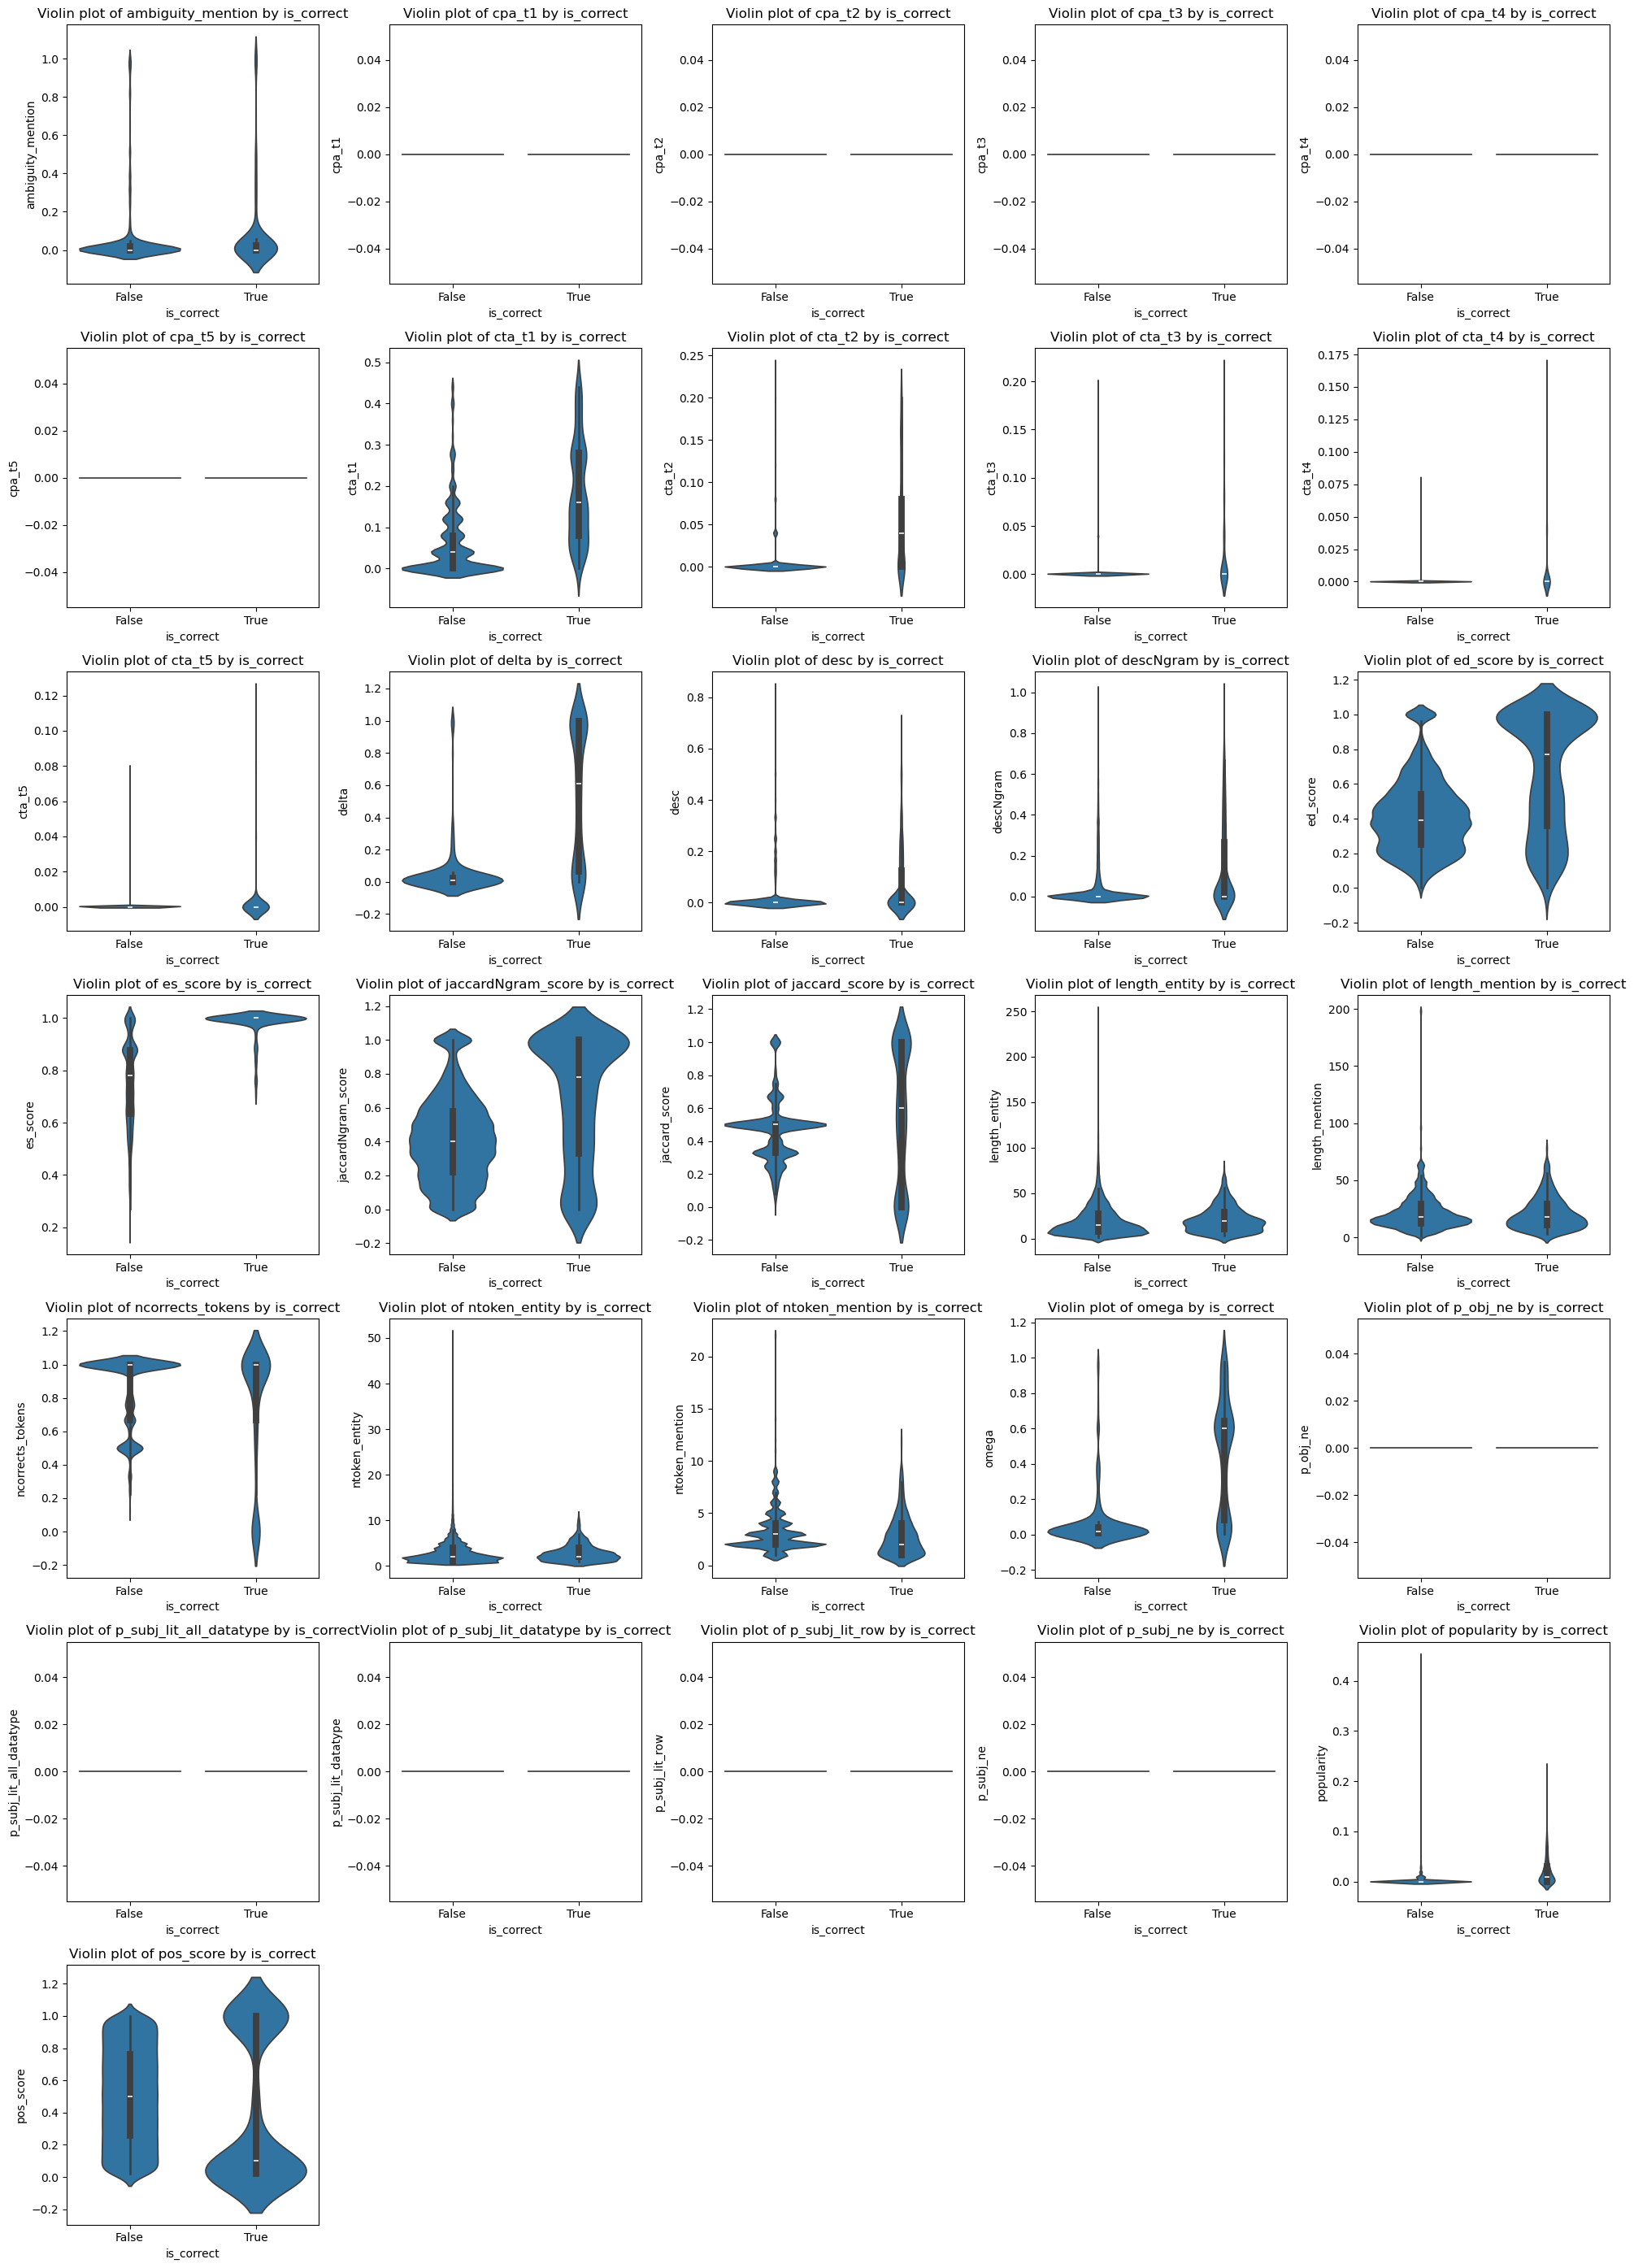

In [32]:
# List of columns to exclude
exclude_columns = ['idRow', 'idColumn', 'index', 'is_correct']

# Get the list of features to plot
features = [col for col in candidate_features.columns if col not in exclude_columns]

# Number of columns in the grid
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create violin plots for each feature
for i, feature in enumerate(features):
    sns.violinplot(x='is_correct', y=feature, data=candidate_features, ax=axes[i])
    axes[i].set_title(f'Violin plot of {feature} by is_correct')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
import scipy.stats as stats
from sklearn import preprocessing

In [10]:
le = preprocessing.LabelEncoder()
encded_is_correct = le.fit_transform(candidate_features['is_correct'])
le.classes_

array([False,  True])

In [13]:
# drop columns with missing values
candidate_features_cor = candidate_features.dropna(axis=1)
candidate_features_cor = candidate_features_cor.drop(columns=['is_correct', 'idRow', 'idColumn', 'index'])
candidate_features_cor["is_correct"] = encded_is_correct


In [21]:
cor_values = []

for col in candidate_features_cor.columns:
    if col != 'is_correct':
        cor_val = {}
        cor_val["feature"] = col
        cor_val["pointbiserialr"], cor_val["P-Value"] = stats.pointbiserialr(candidate_features_cor[col], candidate_features_cor['is_correct'])
        cor_val["pointbiserialr"] = round(cor_val["pointbiserialr"], 2)
        cor_val["P-Value"] = round(cor_val["P-Value"], 2)
        cor_values.append(cor_val)

pointbiserialr_values_df = pd.DataFrame(cor_values)
pointbiserialr_values_df["abs"] = pointbiserialr_values_df["pointbiserialr"].abs()
pointbiserialr_values_df = pointbiserialr_values_df.sort_values(by="abs", ascending=False)
pointbiserialr_values_df = pointbiserialr_values_df.drop(columns=["abs"])
pointbiserialr_values_df

c:\Users\Babak.Khalilvandian\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


,feature,pointbiserialr,P-Value
7,cta_t2,0.36,0.00
8,cta_t3,0.32,0.00
6,cta_t1,0.22,0.00
14,es_score,0.20,0.00
9,cta_t4,0.20,0.00
13,ed_score,0.18,0.00
27,popularity,0.16,0.00
15,jaccardNgram_score,0.14,0.00
12,descNgram,0.13,0.00
10,cta_t5,0.12,0.00


### Answers
- cta features have the highest correlation with candidate correctness. 
    - Hyp 1: Doing a type filtering using the data present in the input table helps filter out irrelevant candidates.

- es-score is the second important feature. Calculated by Lamapi.

- ed-score distance of single char edits.

- Interestingly, pos score is close to zero. making IR system's ranking irrelevant.

